# Testing the Space-time Integral Operator

What _should_ the space-time integral operator look like? One adds up differential elements of a function. Which ones? All 16. This idea mirrors the one I have used for the derivative: multiply a differential by the function and do all the possibilities space-time algebra allows:

$$\int ({\partial t}, \partial \vec{R})(f, \vec{F}) = \int (\partial t f - \partial R \cdot F, \partial t \vec{F} + \partial \vec{R} f + \partial \vec{R} \times \vec{F}) \;.$$

The goal is to sse if this function is consistent with what happens in complex analysis.

Load the libraries.

In [1]:
%%capture
%matplotlib inline
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import math
import unittest

# To get equations the look like, well, equations, use the following.
from sympy.interactive import printing
printing.init_printing(use_latex=True)
from IPython.display import display

# Tools for manipulating quaternions.
from Qs import *

from IPython.core.display import display, HTML, Math, Latex
display(HTML("<style>.container { width:100% !important; }</style>"))

The approach is to use _the same structure_ for the integral as the was used for the derivative of a space-time number function. Here is the code for when the derivatives get taken:

```python
    for sign, var in enumerate(vars):
        if var in these_vars:
            the_16.append(sp.diff(D_signs[sign] * q_1.t, var))
            the_16.append(sp.diff(D_signs[sign] * q_1.x, var))
            the_16.append(sp.diff(D_signs[sign] * q_1.y, var))
            the_16.append(sp.diff(D_signs[sign] * q_1.z, var))
```

There are 2 changes. First, sp.diff() goes to sp.integrate(). Second, the integrate() function has optional limit values. Other than those two changes, the code is the same.

In [2]:
def Iq(q_1: Q, vars: List[sp.Symbol], these_vars: List[sp.Symbol] = None, conj: bool = False, conj_type: int=0, even: bool=False,
       reverse: bool=False, limit: List = None, limits: List = None) -> Q:
    """
    Calculate the space-time number integral composed of 16 terms. The conjugation applies to the differential operator.
    The reverse flag will flip the cross product terms.

    Args:
        q_1         A symbolic expression that returns a space-time number expression.
        vars        A complete list of what 4 symbols are being used.
        these_vars  An optional (possibly shorter) list of symbols to use to take a derivative.
        conj        If one wants to take a conjugate of the differential operator, set this option.
        conj_type   An integer for which term is positive, 0 the default for the standard conjugate.
                    The first, second, and third conjugates flip the other three, keeping the first, 
                    second, and third term positive
        limit       One lower/upper limit list applied to all integrals
        limits      Four lower/upper limit lists applied to each integral
    
    Return:
        Q     The space-time integral
    """
    
    if conj and conj_type and reverse:
        end_q_type = f"{q_1.q_type}I*{conj_type}"
    elif conj and conj_type:
         end_q_type = f"I*{conj_type}{q_1.q_type}"
    elif conj and reverse:
        end_q_type = f"{q_1.q_type}I*"
    elif conj:
        end_q_type = f"I*{q_1.q_type}"
    elif reverse:
        end_q_type = f"{q_1.q_type}I"
    else:
        end_q_type = f"I{q_1.q_type}"
    
    # Check for errors.
    if len(vars) != 4:
        print("Oops: needs to be given 4 symbols. Try again.")
        return q0()
    
    if not q_1.is_symbolic():
        print("Oops, the function needs to be symbolic.")
        return q0()
        
    if these_vars is None:
        these_vars = vars
        
    # Use the_D_signs to apply different conjugates to the differentials.
    D_signs = [1, 1, 1, 1]
    
    if conj:
        if conj_type == 0:
            if even:
                D_signs = [-1, -1, -1, -1]
            else:
                D_signs = [1, -1, -1, -1]
        if conj_type == 1:
            if even:
                D_signs = [-1, -1, 1, 1]
            else:
                D_signs = [-1, 1, -1, -1]
        if conj_type == 2:
            if even:
                D_signs = [-1, 1, -1, 1]
            else:
                D_signs = [-1, -1, 1, -1]
        if conj_type == 3:
            if even:
                D_signs = [-1, 1, 1, -1]
            else:
                D_signs = [-1, -1, -1, 1]
    
    the_16 = []
    
    for sign, var in enumerate(vars):
        if var in these_vars:
            if limits is None:
                the_16.append(sp.integrate(D_signs[sign] * q_1.t, var))
                the_16.append(sp.integrate(D_signs[sign] * q_1.x, var))
                the_16.append(sp.integrate(D_signs[sign] * q_1.y, var))
                the_16.append(sp.integrate(D_signs[sign] * q_1.z, var))
            else:
                if len(limits) != 2:
                    print("Oops, need exactly a list of 2 for limits.")
                    return 0
                    
                the_16.append(sp.integrate(D_signs[sign] * q_1.t, (var, limits[0], limits[1])))
                the_16.append(sp.integrate(D_signs[sign] * q_1.x, (var, limits[0], limits[1])))
                the_16.append(sp.integrate(D_signs[sign] * q_1.y, (var, limits[0], limits[1])))
                the_16.append(sp.integrate(D_signs[sign] * q_1.z, (var, limits[0], limits[1])))
                
        else:
            for _ in range(4):
                the_16.append(0)

    flip = -1 if reverse else 1

    first_term =  the_16[0] - (the_16[5] + the_16[10] + the_16[15])
    second_term = the_16[1] + the_16[4] + flip * the_16[11] - flip * the_16[14]
    third_term =  the_16[2] + the_16[8] + flip * the_16[13] - flip * the_16[7]
    forth_term =  the_16[3] + the_16[12] + flip * the_16[6] - flip * the_16[9]
    
    return Q([first_term.simplify(), second_term.simplify(), third_term.simplify(), forth_term.simplify()], q_type=end_q_type)

In [3]:
def Iqs(q_1: Qs, vars: List[sp.Symbol], these_vars: List[sp.Symbol] = None, conj: bool = False, conj_type: int=0,
        reverse: bool=False, limit: List = None, limits: List = None) -> Qs:
    """
    Calculate the space-time number interval composed of 16 terms. The conjugation applies to the integral operator. The reverse flag will flip the cross product terms.
    
    Args:
        q_1         Symbolic expressions that returns a space-time number expression in a space-time number series.
        vars        A complete list of what 4 symbols are being used.
        these_vars  An optional (possibly shorter) list of symbols to use to take a derivative.
        conj        If one wants to take a conjugate of the differential operator, set this option.
        conj_type   An integer for which term is positive, 0 the default for the standard conjugate.
                    The first, second, and third conjugates flip the other three, keeping the first, 
                    second, and third term positive
        limit       One lower/upper limit list applied to all integrals
        limits      Four lower/upper limit lists applied to each integral
        
    Return:
        Q     The space-time integral
    """
    
    results = [Iq(q, vars, these_vars, conj, conj_type, reverse) for q in q_1.qs]
    
    return Qs(results, qs_type=q_1.qs_type, rows=q_1.rows, columns=q_1.columns)

Test that the function works on a real-valued cubic function:

In [4]:
t, x, y, z = sp.symbols("t x y z")
q_t = Q([t,0, 0, 0])
q_t_3 = product(product(q_t, q_t), q_t)
q_t_3.print_state("q_t³")
I_t_3_dt = Iq(q_t_3, [t, x, y, z], [t])
I_t_3_dt.print_state("I_t³_dt")

q_t³
(t**3, 0, 0, 0) 

I_t³_dt
(t**4/4, 0, 0, 0) 



That looks right. Check that the fundamental rule of calculus works:

In [5]:
I_D_t_3_dt = Iq(Dq(q_t_3, [t, x, y, z], [t]), [t, x, y, z], [t])
I_D_t_3_dt.print_state("I_D_t³_dt")

I_D_t³_dt
(t**3, 0, 0, 0) 



It turns out not to matter if one does the derivative first or the integral.

In [6]:
D_I_t_3_dt = Dq(Iq(q_t_3, [t, x, y, z], [t]), [t, x, y, z], [t])
D_I_t_3_dt.print_state("D_I_t³_dt")

D_I_t³_dt
(t**3, 0, 0, 0) 



Now a complex-valued cubic:

q_tx³


I_tx³_dt dx


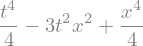

In [7]:
q_tx = Q([t, x, 0, 0])
q_tx_3 = product(product(q_tx, q_tx), q_tx)
q_tx_3.expand().display("q_tx³")
I_tx_3_dt_dx = Iq(q_tx_3, [t, x, y, z], [t, x])
I_tx_3_dt_dx.display("I_tx³_dt dx")

Is there a fundamental theorem for complex calculus?

In [8]:
I_D_tx_3_dt_dx = Iq(Dq(q_tx_3, [t, x, y, z], [t, x]), [t, x, y, z], [t, x])
I_D_tx_3_dt_dx.expand().display("I_D_tx³_dt_dx")

I_D_tx³_dt_dx


Oops, the cubic function is analytic in $q$, so after the derivative, the result is zero. Try the reverse order:

In [9]:
D_I_tx_3_dt_dx = Dq(Iq(q_tx_3, [t, x, y, z], [t, x]), [t, x, y, z], [t, x])
D_I_tx_3_dt_dx.expand().display("D_I_tx³_dt_dx")

D_I_tx³_dt_dx


Although this is non-zero, the original function was not recovered.

The **fundamental theorem of calculus** sounds too fundamental to not understand. We must know how to recover an original analytic function after operating on it with a differential operator and then an integral.

The Cauchy-Riemann equations has two different relations. One is the real/real versus imaginary/imaginary. The other is imaginary/real versus real/imaginary. There may be a minus sign tossed in here or there as need be.

First see if the real part of the function can be recovered using both real/real and imaginary/imaginary derivatives and integrals.

In [10]:
I_D_tx_3_dt__dt = Iq(Dq(q_tx_3, [t, x, y, z], [t]), [t, x, y, z], [t])
I_D_tx_3_dt__dt.expand().display("I_D_tx³_dt__dt")

I_D_tx³_dt__dt


Nice, the real term is the real term of the original cubic function. No partial credit is given for the imaginary term. There are costs to using only the reals. Here is what was done using symbols:

$$(f, 0, 0, 0) = \rm{Re}\left(\int d(t, 0, 0, 0) \frac{\partial(f, F_x, 0, 0)}{\partial (t, 0, 0, 0)} \right)$$

This is one way to recover the real part of an analytic function.

Now try only the imaginaries:

In [11]:
I_D_tx_3_dx__dx = Iq(Dq(q_tx_3, [t, x, y, z], [x]), [t, x, y, z], [x])
I_D_tx_3_dx__dx.expand().display("I_D_tx³_dx__dx")

I_D_tx³_dx__dx


The imaginary is off by a sign. Use a conjugate operator:

In [12]:
I_D_tx_3_dx_c__dx = Iq(Dq(q_tx_3, [t, x, y, z], [x], conj=True), [t, x, y, z], [x])
I_D_tx_3_dx_c__dx.expand().display("I_D_tx³_dx*__dx")

I_D_tx³_dx*__dx


This is a little unsatisfying since we are just "grabbing needed parts" instead of getting one expression that recovers the original function. I tried reversing the integral and derivative, tossing in a conjugate, and got this clean result.

In [13]:
D_I_tx_3_dx_c__dx = Dq(Iq(q_tx_3, [t, x, y, z], [x], conj=True), [t, x, y, z], [x])
D_I_tx_3_dx_c__dx.expand().display("D_I_tx³_dx*__dx")

D_I_tx³_dx*__dx


$$\frac{\partial}{\partial x}\int d x^* (t, x, 0, 0)^3 = (t, x, 0, 0)^3$$

Bingo, bingo for recovering the original function using the variable $x$. Let's find the derivative/integral using just time.

In [14]:
D_I_tx_3_dt_c__dt = Dq(Iq(q_tx_3, [t, x, y, z], [t]), [t, x, y, z], [t])
D_I_tx_3_dt_c__dt.expand().display("D_I_tx³_dt__dt")

D_I_tx³_dt__dt


Either of these work to recover the full function:

$$(f, F_x, 0, 0) = \frac{\partial}{\partial (t, 0, 0, 0)} \int d(t, 0, 0, 0)(f, F_x, 0, 0)$$

$$(f, F_x, 0, 0) = \frac{\partial}{\partial (0, x, 0, 0)} \int d(0, x, 0, 0)^*(f, F_x, 0, 0)$$

There should be another path, using a mixture of real/imaginary and imaginary/real derivatives and integrals.

In [15]:
I_D_tx_3_dx_c__dt = Iq(Dq(q_tx_3, [t, x, y, z], [x], conj=True), [t, x, y, z], [t])
I_D_tx_3_dx_c__dt.expand().display("I_D_tx³_dx*__dt")

I_D_tx³_dx*__dt


In [16]:
I_D_tx_3_dt__dx = Iq(Dq(q_tx_3, [t, x, y, z], [t]), [t, x, y, z], [x])
I_D_tx_3_dt__dx.expand().display("I_D_tx³_dt__dx")

I_D_tx³_dt__dx


See if the trick of reversing order works to get the entire function.

In [17]:
D_I_tx_3_dx__dt = Dq(Iq(q_tx_3, [t, x, y, z], [x]), [t, x, y, z], [t])
D_I_tx_3_dx__dt.expand().display("D_I_tx³_dx__dt")

D_I_tx³_dx__dt


This time it does not.

The full function can be recovered like so:

$$(f, F_x, 0, 0) = \rm{Re} \left( \int d(0, x, 0, 0)^* \frac{\partial(f, F_x, 0, 0)}{(t, 0, 0, 0)} \right)+ \rm{Im} \left(\int d(t, 0, 0, 0) \frac{\partial(f, F_x, 0, 0)}{(0, x, 0, 0)} \right)$$

In [18]:
I_D_tx_3_dx__dt = Iq(Dq(q_tx_3, [t, x, y, z], [x]), [t, x, y, z], [t])
I_D_tx_3_dx__dt.expand().display("I_D_tx³_dx__dt")
I_D_tx_3_dt__dx = Iq(Dq(q_tx_3, [t, x, y, z], [t]), [t, x, y, z], [x])
I_D_tx_3_dt__dx.expand().display("I_D_tx³_dt__dx")
selective_dif = dif(vector_q(I_D_tx_3_dt__dx), scalar_q(I_D_tx_3_dx__dt))
selective_dif.display("selective dif")

I_D_tx³_dx__dt


I_D_tx³_dt__dx


selective dif


In [19]:
I_D_tx_3_c_dx__dt = Iq(Dq(q_tx_3, [t, x, y, z], [x], conj=True), [t, x, y, z], [t])
I_D_tx_3_c_dx__dt.expand().display("I_D_tx³_dx*__dt")
I_D_tx_3_c_dx__dt = Iq(Dq(q_tx_3, [t, x, y, z], [x]), [t, x, y, z], [t], conj=True)
I_D_tx_3_c_dx__dt.expand().display("I_D_tx³_dx*__dt*")
I_D_tx_3_c_dx__dt = Iq(Dq(q_tx_3, [t, x, y, z], [x], conj=True), [t, x, y, z], [t], conj=True)
I_D_tx_3_c_dx__dt.expand().display("I_D_tx³_dx*__dt*")

I_D_tx³_dx*__dt


I_D_tx³_dx*__dt*


I_D_tx³_dx*__dt*


In [20]:
I_D_tx_3_dt__dt = Iq(Dq(q_tx_3, [t, x, y, z], [t], conj=True), [t, x, y, z], [t])
I_D_tx_3_dt__dt.expand().display("I_D_tx³_dt__dt")
I_D_tx_3_c_dt__dt = Iq(Dq(q_tx_3, [t, x, y, z], [t], conj=True), [t, x, y, z], [t])
I_D_tx_3_c_dt__dt.expand().display("I_D_tx³_dt*__dt")
I_D_tx_3_c_dt__dt = Iq(Dq(q_tx_3, [t, x, y, z], [t]), [t, x, y, z], [t], conj=True)
I_D_tx_3_c_dt__dt.expand().display("I_D_tx³_dt*__dt*")
I_D_tx_3_c_dt__dt = Iq(Dq(q_tx_3, [t, x, y, z], [t], conj=True), [t, x, y, z], [t], conj=True)
I_D_tx_3_c_dt__dt.expand().display("I_D_tx³_dt*__dt*")
I_D_tx_3_dx__dx = Iq(Dq(q_tx_3, [t, x, y, z], [x]), [t, x, y, z], [x])
I_D_tx_3_dx__dx.expand().display("I_D_tx³_dx__dx")
I_D_tx_3_c_dx__dx = Iq(Dq(q_tx_3, [t, x, y, z], [x], conj=True), [t, x, y, z], [x])
I_D_tx_3_c_dx__dx.expand().display("I_D_tx³_dx*__dx")
I_D_tx_3_c_dx__dx = Iq(Dq(q_tx_3, [t, x, y, z], [x]), [t, x, y, z], [x], conj=True)
I_D_tx_3_c_dx__dx.expand().display("I_D_tx³_dx*__dx*")
I_D_tx_3_c_dx__dx = Iq(Dq(q_tx_3, [t, x, y, z], [x], conj=True), [t, x, y, z], [x], conj=True)
I_D_tx_3_c_dx__dx.expand().display("I_D_tx³_dx*__dx*")

I_D_tx³_dt__dt


I_D_tx³_dt*__dt


I_D_tx³_dt*__dt*


I_D_tx³_dt*__dt*


I_D_tx³_dx__dx


I_D_tx³_dx*__dx


I_D_tx³_dx*__dx*


I_D_tx³_dx*__dx*


q_txyz³


I_tx³_dt


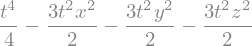

I_tx³_dx


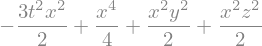

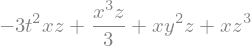

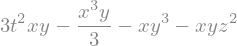

I_tx³_dt_dx_dy_dz


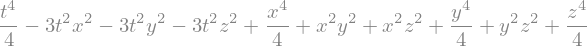

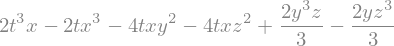

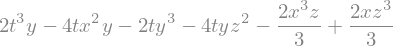

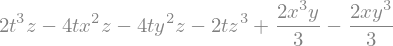

In [21]:
q_txyz = Q([t, x, y, z])
q_txyz_3 = product(product(q_txyz, q_txyz), q_txyz).expand()
q_txyz_3.display("q_txyz³")
I_txyz_3_dt = Iq(q_txyz_3, [t, x, y, z], [t]).expand()
I_txyz_3_dt.display("I_tx³_dt")
I_txyz_3_dx = Iq(q_txyz_3, [t, x, y, z], [x]).expand()
I_txyz_3_dx.display("I_tx³_dx")
I_txyz_3_dtdxdydz = Iq(q_txyz_3, [t, x, y, z], [t, x, y, z]).expand()
I_txyz_3_dtdxdydz.display("I_tx³_dt_dx_dy_dz")

D_I_txyz³_dx*dy*dz*__dx


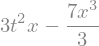

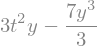

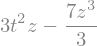

In [22]:
D_I_txyz_3_dxdydz_c__dxdydz = Dq(Iq(q_txyz_3, [t, x, y, z], [x, y, z], conj=True), [t, x, y, z], [x, y, z])
D_I_txyz_3_dxdydz_c__dxdydz.expand().display("D_I_txyz³_dx*dy*dz*__dx")

In [23]:
q_txyz = Q([t, x, y, z])
q_txyz_3 = product(product(q_txyz, q_txyz), q_txyz).expand()
q_txyz_3.display("q_txyz³")
D_txyz_3_dt = Dq(q_txyz_3, [t, x, y, z], [t]).expand()
D_txyz_3_dt.display("D_txyz³_dt")
D_txyz_3_dx = Dq(q_txyz_3, [t, x, y, z], [x]).expand()
D_txyz_3_dx.display("D_txyz³_dx")
D_txyz_3_dy = Dq(q_txyz_3, [t, x, y, z], [y]).expand()
D_txyz_3_dy.display("D_txyz³_dy")
D_txyz_3_dz = Dq(q_txyz_3, [t, x, y, z], [z]).expand()
D_txyz_3_dz.display("D_txyz³_dz")
D_txyz_3_dtdxdydz = Dq(q_txyz_3, [t, x, y, z]).expand()
D_txyz_3_dtdxdydz.display("D_txyx³_dtdxdydz")

q_txyz³


D_txyz³_dt


D_txyz³_dx


D_txyz³_dy


D_txyz³_dz


D_txyx³_dtdxdydz


Now there are mixed terms, various products of $x$, $y$, and $z$. Cubic functions remain analytic for _complex_ values:

In [24]:
q_tx = Q([t, x, 0, 0])
q_tx_3 = product(product(q_tx, q_tx), q_tx)
q_tx_3.display("q_tx³")
D_tx_3_dt = Dq(q_tx_3, [t, x, y, z], [t])
D_tx_3_dt.display("D_txyz³_dt")
D_tx_3_dx = Dq(q_tx_3, [t, x, y, z], [x])
D_tx_3_dx.display("D_txyz³_dx")
D_tx_3_dy = Dq(q_tx_3, [t, x, y, z], [y])
D_tx_3_dy.print_state("D_txyz³_dy")
D_tx_3_dz = Dq(q_tx_3, [t, x, y, z], [z])
D_tx_3_dz.print_state("D_tx³_dz")
D_tx_3_dtdx = Dq(q_tx_3, [t, x, y, z], [t, x])
D_tx_3_dtdx.print_state("D_tx³_dtdx")

q_tx³


D_txyz³_dt


D_txyz³_dx


D_txyz³_dy
(0, 0, 0, 0) 

D_tx³_dz
(0, 0, 0, 0) 

D_tx³_dtdx
(0, 0, 0, 0) 



This remains a consistent theme: everything done in complex analysis is exactly mirrored with complex-valued space-time numbers. When more imaginaries are used, then the divergence of what are complex-valued analytic functions becomes non-zero. When the divergence is zero, one often says it is conservative, as in no energy is used for the pattern seen. Under that interpretation, a move from a complex analytic function to a full space-time number function involves the input or production of energy.

# The Tests

In [25]:
class TestDq(unittest.TestCase):
    """Test states."""
    
    def test_Dq_derivative(self):
        T, X, Y, Z = sp.symbols("T X Y Z")
        TXYZ = [T, X, Y, Z]
            
        self.assertTrue(equal(Dq(q1(), TXYZ), q0()))
        self.assertTrue(equal(Dq(Q([T, X, Y, Z]), [T]), q0()))
        
        q_TX = Q([T, X, 0, 0])
        q_TX_3 = product(product(q_TX, q_TX), q_TX)
        D_q_TX_3 = Dq(q_TX, TXYZ)
        self.assertTrue(D_q_TX_3.t == 0)
        self.assertTrue(D_q_TX_3.x == 0)
        self.assertTrue(D_q_TX_3.y == 0)
        self.assertTrue(D_q_TX_3.z == 0)
        
        q_TXYZ = Q(TXYZ)
        q_TXYZ_3 = product(product(q_TXYZ, q_TXYZ), q_TXYZ)
        D_q_TXYZ_3 = Dq(q_TXYZ_3, TXYZ)
        self.assertTrue(D_q_TXYZ_3.t == -6*T**2 + 2*X**2 + 2*Y**2 + 2*Z**2)
        self.assertTrue(D_q_TXYZ_3.x ==  0)
        self.assertTrue(D_q_TXYZ_3.y ==  0)
        self.assertTrue(D_q_TXYZ_3.z ==  0)
        
    def test_Dqs_derivative(self):
        T, X, Y, Z = sp.symbols("T X Y Z")
        TXYZ = [T, X, Y, Z]
            
        self.assertTrue(equals(Dqs(Qs([q1()]), TXYZ), q0s()))
        self.assertTrue(equals(Dqs(Qs([Q([T, X, Y, Z])]), [T]), q0s()))
        
        q_TX = Q([T, X, 0, 0])
        q_TX_3 = product(product(q_TX, q_TX), q_TX)
        
        q_TXYZ = Q(TXYZ)
        q_TXYZ_3 = product(product(q_TXYZ, q_TXYZ), q_TXYZ)
        
        qs_TX_3_TXYZ_3 = Qs([q_TX_3, q_TXYZ_3])
        
        D_q_TX_3_TXYZ_3 = Dqs(qs_TX_3_TXYZ_3, TXYZ)
        
        self.assertTrue(D_q_TX_3_TXYZ_3.qs[0].t == 0)
        self.assertTrue(D_q_TX_3_TXYZ_3.qs[0].x == 0)
        self.assertTrue(D_q_TX_3_TXYZ_3.qs[0].y == 0)
        self.assertTrue(D_q_TX_3_TXYZ_3.qs[0].z == 0)
        
        self.assertTrue(D_q_TX_3_TXYZ_3.qs[1].t == -6*T**2 + 2*X**2 + 2*Y**2 + 2*Z**2)
        self.assertTrue(D_q_TX_3_TXYZ_3.qs[1].x ==  0)
        self.assertTrue(D_q_TX_3_TXYZ_3.qs[1].y ==  0)
        self.assertTrue(D_q_TX_3_TXYZ_3.qs[1].z ==  0)
        
suite = unittest.TestLoader().loadTestsFromModule(TestDq())
unittest.TextTestRunner().run(suite);

..

Oops, the function needs to be symbolic.
Oops: needs to be given 4 symbols. Try again.
Oops, the function needs to be symbolic.
Oops: needs to be given 4 symbols. Try again.



----------------------------------------------------------------------
Ran 2 tests in 0.155s

OK


In [26]:
q_txyz = Q([t, x, y, z])
q_txyz_3 = product(product(q_txyz, q_txyz), q_txyz).expand()
q_txyz_3.display()

In [30]:
conjugates = [[False, 0, "", False], 
              [False, 0, "", True], 
              [True, 0, "*", False], 
              [True, 0, "*", True], 
              [True, 1, "*1", False], 
              [True, 1, "*1", True], 
              [True, 2, "*2", False], 
              [True, 2, "*2", True]]
i_conj = ["*", "*1", "*2"]
even = {True: "e", False: ""}
all_t = set()
all_t_tags = {}
all_x = set()
all_x_tags = {}
all_y = set()
all_y_tags = {}
all_z = set()
all_z_tags = {}

for I_conjugate in conjugates:
    for D_conjugate in conjugates:
        ID_q=Iq(Dq(q_txyz_3, [t, x, y, z], [t, x, y, z], conj=D_conjugate[0], conj_type=D_conjugate[1], even=D_conjugate[3]), [t, x, y, z], [t, x, y, z], conj=I_conjugate[0], conj_type=I_conjugate[1], even=I_conjugate[3]).expand()
        tag = f"I{I_conjugate[2]}{even[I_conjugate[3]]} D{D_conjugate[2]}{even[D_conjugate[3]]} F "
        print(tag)
        display(ID_q.t)
        all_t.add(ID_q.t)
        key = str(ID_q.t)
        all_t_tags[key] = tag
        all_x.add(ID_q.x)
        key = str(ID_q.x)
        all_x_tags[key] = tag
        all_y.add(ID_q.y)
        key = str(ID_q.y)
        all_y_tags[key] = tag
        all_z.add(ID_q.z)
        key = str(ID_q.z)
        all_z_tags[key] = tag
        
        for i in range(3):
            ID_q=Iq(Dq(conj(q_txyz_3, conj_type=i), [t, x, y, z], [t, x, y, z], conj=D_conjugate[0], conj_type=D_conjugate[1], even=D_conjugate[3]), [t, x, y, z], [t, x, y, z], conj=I_conjugate[0], conj_type=I_conjugate[1], even=I_conjugate[3]).expand()
            tag = f"I{I_conjugate[2]}{even[I_conjugate[3]]} D{D_conjugate[2]}{even[D_conjugate[3]]} F{i_conj[i]}"
            print(tag)
            display(ID_q.t)
            all_t.add(ID_q.t)
            key = str(ID_q.t)
            all_t_tags[key] = tag
            all_x.add(ID_q.x)
            key = str(ID_q.x)
            all_x_tags[key] = tag
            all_y.add(ID_q.y)
            key = str(ID_q.y)
            all_y_tags[key] = tag
            all_z.add(ID_q.z)
            key = str(ID_q.z)
            all_z_tags[key] = tag

for I_conjugate in conjugates:
    for D_conjugate in conjugates:
        ID_q=Iq(Dq(q_txyz_3, [t, x, y, z], [t, x, y, z], conj=D_conjugate[0], conj_type=D_conjugate[1], even=D_conjugate[3], reverse=True), [t, x, y, z], [t, x, y, z], conj=I_conjugate[0], conj_type=I_conjugate[1], even=I_conjugate[3]).expand()
        tag = f"Rev I{I_conjugate[2]}{even[I_conjugate[3]]} D{D_conjugate[2]}{even[D_conjugate[3]]} F"
        print(tag)
        display(ID_q.t)
        all_t.add(ID_q.t)
        key = str(ID_q.t)
        all_t_tags[key] = tag
        all_x.add(ID_q.x)
        key = str(ID_q.x)
        all_x_tags[key] = tag
        all_y.add(ID_q.y)
        key = str(ID_q.y)
        all_y_tags[key] = tag
        all_z.add(ID_q.z)
        key = str(ID_q.z)
        all_z_tags[key] = tag
        , even=D_conjugate[3]
        for i in range(3):
            ID_q=Iq(Dq(conj(q_txyz_3, conj_type=i), [t, x, y, z], [t, x, y, z], conj=D_conjugate[0], conj_type=D_conjugate[1], even=D_conjugate[3], reverse=True), [t, x, y, z], [t, x, y, z], conj=I_conjugate[0], conj_type=I_conjugate[1], even=I_conjugate[3]).expand()
            tag = f"Rev I{I_conjugate[2]}{even[I_conjugate[3]]} D{D_conjugate[2]}{even[D_conjugate[3]]} F{i_conj[i]}"
            print(tag)
            display(ID_q.t)
            all_t.add(ID_q.t)
            key = str(ID_q.t)
            all_t_tags[key] = tag
            all_x.add(ID_q.x)
            key = str(ID_q.x)
            all_x_tags[key] = tag
            all_y.add(ID_q.y)
            key = str(ID_q.y)
            all_y_tags[key] = tag
            all_z.add(ID_q.z)
            key = str(ID_q.z)
            all_z_tags[key] = tag

for I_conjugate in conjugates:
    for D_conjugate in conjugates:
        DI_q=Dq(Iq(q_txyz_3, [t, x, y, z], [t, x, y, z], conj=D_conjugate[0], conj_type=D_conjugate[1], even=D_conjugate[3]), [t, x, y, z], [t, x, y, z], conj=I_conjugate[0], conj_type=I_conjugate[1], even=I_conjugate[3]).expand()
        tag = f"D{D_conjugate[2]}{even[D_conjugate[3]]} I{I_conjugate[2]}{even[I_conjugate[3]]} F"
        print(tag)
        display(DI_q.t)
        all_t.add(DI_q.t)
        key = str(DI_q.t)
        all_t_tags[key] = tag
        all_x.add(DI_q.x)
        key = str(DI_q.x)
        all_x_tags[key] = tag
        all_y.add(DI_q.y)
        key = str(DI_q.y)
        all_y_tags[key] = tag
        all_z.add(DI_q.z)
        key = str(DI_q.z)
        all_z_tags[key] = tag
        
        for i in range(3):
            DI_q=Dq(Iq(conj(q_txyz_3, conj_type=i), [t, x, y, z], [t, x, y, z], conj=D_conjugate[0], conj_type=D_conjugate[1], even=D_conjugate[3]), [t, x, y, z], [t, x, y, z], conj=I_conjugate[0], conj_type=I_conjugate[1], even=I_conjugate[3]).expand()
            tag = f"D{D_conjugate[2]}{even[D_conjugate[3]]} I{I_conjugate[2]}{even[I_conjugate[3]]} F{i_conj[i]}"
            print(tag)
            display(DI_q.t)
            all_t.add(ID_q.t)
            key = str(DI_q.t)
            all_t_tags[key] = tag
            all_x.add(DI_q.x)
            key = str(DI_q.x)
            all_x_tags[key] = tag
            all_y.add(DI_q.y)
            key = str(DI_q.y)
            all_y_tags[key] = tag
            all_z.add(DI_q.z)
            key = str(DI_q.z)
            all_z_tags[key] = tag

for I_conjugate in conjugates:
    for D_conjugate in conjugates:
        DI_q=Dq(Iq(q_txyz_3, [t, x, y, z], [t, x, y, z], conj=I_conjugate[0], conj_type=I_conjugate[1], even=I_conjugate[3], reverse=True), [t, x, y, z], [t, x, y, z], conj=D_conjugate[0], conj_type=D_conjugate[1], even=D_conjugate[3]).expand()
        tag = f"Rev D{D_conjugate[2]}{even[D_conjugate[3]]} I{I_conjugate[2]}{even[I_conjugate[3]]} F"
        print(tag)
        display(DI_q.t)
        all_t.add(DI_q.t)
        key = str(DI_q.t)
        all_t_tags[key] = tag
        all_x.add(DI_q.x)
        key = str(DI_q.x)
        all_x_tags[key] = tag
        all_y.add(DI_q.y)
        key = str(DI_q.y)
        all_y_tags[key] = tag
        all_z.add(DI_q.z)
        key = str(DI_q.z)
        all_z_tags[key] = tag
        
        for i in range(3):
            DI_q=Dq(Iq(conj(q_txyz_3, conj_type=i), [t, x, y, z], [t, x, y, z], conj=I_conjugate[0], conj_type=I_conjugate[1], even=I_conjugate[3], reverse=True), [t, x, y, z], [t, x, y, z], conj=D_conjugate[0], conj_type=D_conjugate[1], even=D_conjugate[3]).expand()
            tag = f"Rev D{D_conjugate[2]}{even[D_conjugate[3]]} I{I_conjugate[2]}{even[I_conjugate[3]]} F{i_conj[i]}"
            print(tag)
            display(DI_q.t)
            all_t.add(DI_q.t)
            key = str(DI_q.t)
            all_t_tags[key] = tag
            all_x.add(DI_q.x)
            key = str(DI_q.x)
            all_x_tags[key] = tag
            all_y.add(DI_q.y)
            key = str(DI_q.y)
            all_y_tags[key] = tag
            all_z.add(DI_q.z)
            key = str(DI_q.z)
            all_z_tags[key] = tag
        
#for all_ID_q in all_ID_qs:
#    all_ID_q.display()

I D F 


I D F*


I D F*1


I D F*2


I De F 


I De F*


I De F*1


I De F*2


I D* F 


I D* F*


I D* F*1


I D* F*2


I D*e F 


I D*e F*


I D*e F*1


I D*e F*2


I D*1 F 


I D*1 F*


I D*1 F*1


I D*1 F*2


I D*1e F 


I D*1e F*


I D*1e F*1


I D*1e F*2


I D*2 F 


I D*2 F*


I D*2 F*1


I D*2 F*2


I D*2e F 


I D*2e F*


I D*2e F*1


I D*2e F*2


Ie D F 


Ie D F*


Ie D F*1


Ie D F*2


Ie De F 


Ie De F*


Ie De F*1


Ie De F*2


Ie D* F 


Ie D* F*


Ie D* F*1


Ie D* F*2


Ie D*e F 


Ie D*e F*


Ie D*e F*1


Ie D*e F*2


Ie D*1 F 


Ie D*1 F*


Ie D*1 F*1


Ie D*1 F*2


Ie D*1e F 


Ie D*1e F*


Ie D*1e F*1


Ie D*1e F*2


Ie D*2 F 


Ie D*2 F*


Ie D*2 F*1


Ie D*2 F*2


Ie D*2e F 


Ie D*2e F*


Ie D*2e F*1


Ie D*2e F*2


I* D F 


I* D F*


I* D F*1


I* D F*2


I* De F 


I* De F*


I* De F*1


I* De F*2


I* D* F 


I* D* F*


I* D* F*1


I* D* F*2


I* D*e F 


I* D*e F*


I* D*e F*1


I* D*e F*2


I* D*1 F 


I* D*1 F*


I* D*1 F*1


I* D*1 F*2


I* D*1e F 


I* D*1e F*


I* D*1e F*1


I* D*1e F*2


I* D*2 F 


I* D*2 F*


I* D*2 F*1


I* D*2 F*2


I* D*2e F 


I* D*2e F*


I* D*2e F*1


I* D*2e F*2


I*e D F 


I*e D F*


I*e D F*1


I*e D F*2


I*e De F 


I*e De F*


I*e De F*1


I*e De F*2


I*e D* F 


I*e D* F*


I*e D* F*1


I*e D* F*2


I*e D*e F 


I*e D*e F*


I*e D*e F*1


I*e D*e F*2


I*e D*1 F 


I*e D*1 F*


I*e D*1 F*1


I*e D*1 F*2


I*e D*1e F 


I*e D*1e F*


I*e D*1e F*1


I*e D*1e F*2


I*e D*2 F 


I*e D*2 F*


I*e D*2 F*1


I*e D*2 F*2


I*e D*2e F 


I*e D*2e F*


I*e D*2e F*1


I*e D*2e F*2


I*1 D F 


I*1 D F*


I*1 D F*1


I*1 D F*2


I*1 De F 


I*1 De F*


I*1 De F*1


I*1 De F*2


I*1 D* F 


I*1 D* F*


I*1 D* F*1


I*1 D* F*2


I*1 D*e F 


I*1 D*e F*


I*1 D*e F*1


I*1 D*e F*2


I*1 D*1 F 


I*1 D*1 F*


I*1 D*1 F*1


I*1 D*1 F*2


I*1 D*1e F 


I*1 D*1e F*


I*1 D*1e F*1


I*1 D*1e F*2


I*1 D*2 F 


I*1 D*2 F*


I*1 D*2 F*1


I*1 D*2 F*2


I*1 D*2e F 


I*1 D*2e F*


I*1 D*2e F*1


I*1 D*2e F*2


I*1e D F 


I*1e D F*


I*1e D F*1


I*1e D F*2


I*1e De F 


I*1e De F*


I*1e De F*1


I*1e De F*2


I*1e D* F 


I*1e D* F*


I*1e D* F*1


I*1e D* F*2


I*1e D*e F 


I*1e D*e F*


I*1e D*e F*1


I*1e D*e F*2


I*1e D*1 F 


I*1e D*1 F*


I*1e D*1 F*1


I*1e D*1 F*2


I*1e D*1e F 


I*1e D*1e F*


I*1e D*1e F*1


I*1e D*1e F*2


I*1e D*2 F 


I*1e D*2 F*


I*1e D*2 F*1


I*1e D*2 F*2


I*1e D*2e F 


I*1e D*2e F*


I*1e D*2e F*1


I*1e D*2e F*2


I*2 D F 


I*2 D F*


I*2 D F*1


I*2 D F*2


I*2 De F 


I*2 De F*


I*2 De F*1


I*2 De F*2


I*2 D* F 


I*2 D* F*


I*2 D* F*1


I*2 D* F*2


I*2 D*e F 


I*2 D*e F*


I*2 D*e F*1


I*2 D*e F*2


I*2 D*1 F 


I*2 D*1 F*


I*2 D*1 F*1


I*2 D*1 F*2


I*2 D*1e F 


I*2 D*1e F*


I*2 D*1e F*1


I*2 D*1e F*2


I*2 D*2 F 


I*2 D*2 F*


I*2 D*2 F*1


I*2 D*2 F*2


I*2 D*2e F 


I*2 D*2e F*


I*2 D*2e F*1


I*2 D*2e F*2


I*2e D F 


I*2e D F*


I*2e D F*1


I*2e D F*2


I*2e De F 


I*2e De F*


I*2e De F*1


I*2e De F*2


I*2e D* F 


I*2e D* F*


I*2e D* F*1


I*2e D* F*2


I*2e D*e F 


I*2e D*e F*


I*2e D*e F*1


I*2e D*e F*2


I*2e D*1 F 


I*2e D*1 F*


I*2e D*1 F*1


I*2e D*1 F*2


I*2e D*1e F 


I*2e D*1e F*


I*2e D*1e F*1


I*2e D*1e F*2


I*2e D*2 F 


I*2e D*2 F*


I*2e D*2 F*1


I*2e D*2 F*2


I*2e D*2e F 


I*2e D*2e F*


I*2e D*2e F*1


I*2e D*2e F*2


Rev I D F


Rev I D F*


Rev I D F*1


Rev I D F*2


Rev I De F


Rev I De F*


Rev I De F*1


Rev I De F*2


Rev I D* F


Rev I D* F*


Rev I D* F*1


Rev I D* F*2


Rev I D*e F


Rev I D*e F*


Rev I D*e F*1


Rev I D*e F*2


Rev I D*1 F


Rev I D*1 F*


Rev I D*1 F*1


Rev I D*1 F*2


Rev I D*1e F


Rev I D*1e F*


Rev I D*1e F*1


Rev I D*1e F*2


Rev I D*2 F


Rev I D*2 F*


Rev I D*2 F*1


Rev I D*2 F*2


Rev I D*2e F


Rev I D*2e F*


Rev I D*2e F*1


Rev I D*2e F*2


Rev Ie D F


Rev Ie D F*


Rev Ie D F*1


Rev Ie D F*2


Rev Ie De F


Rev Ie De F*


Rev Ie De F*1


Rev Ie De F*2


Rev Ie D* F


Rev Ie D* F*


Rev Ie D* F*1


Rev Ie D* F*2


Rev Ie D*e F


Rev Ie D*e F*


Rev Ie D*e F*1


Rev Ie D*e F*2


Rev Ie D*1 F


Rev Ie D*1 F*


Rev Ie D*1 F*1


Rev Ie D*1 F*2


Rev Ie D*1e F


Rev Ie D*1e F*


Rev Ie D*1e F*1


Rev Ie D*1e F*2


Rev Ie D*2 F


Rev Ie D*2 F*


Rev Ie D*2 F*1


Rev Ie D*2 F*2


Rev Ie D*2e F


Rev Ie D*2e F*


Rev Ie D*2e F*1


Rev Ie D*2e F*2


Rev I* D F


Rev I* D F*


Rev I* D F*1


Rev I* D F*2


Rev I* De F


Rev I* De F*


Rev I* De F*1


Rev I* De F*2


Rev I* D* F


Rev I* D* F*


Rev I* D* F*1


Rev I* D* F*2


Rev I* D*e F


Rev I* D*e F*


Rev I* D*e F*1


Rev I* D*e F*2


Rev I* D*1 F


Rev I* D*1 F*


Rev I* D*1 F*1


Rev I* D*1 F*2


Rev I* D*1e F


Rev I* D*1e F*


Rev I* D*1e F*1


Rev I* D*1e F*2


Rev I* D*2 F


Rev I* D*2 F*


Rev I* D*2 F*1


Rev I* D*2 F*2


Rev I* D*2e F


Rev I* D*2e F*


Rev I* D*2e F*1


Rev I* D*2e F*2


Rev I*e D F


Rev I*e D F*


Rev I*e D F*1


Rev I*e D F*2


Rev I*e De F


Rev I*e De F*


Rev I*e De F*1


Rev I*e De F*2


Rev I*e D* F


Rev I*e D* F*


Rev I*e D* F*1


Rev I*e D* F*2


Rev I*e D*e F


Rev I*e D*e F*


Rev I*e D*e F*1


Rev I*e D*e F*2


Rev I*e D*1 F


Rev I*e D*1 F*


Rev I*e D*1 F*1


Rev I*e D*1 F*2


Rev I*e D*1e F


Rev I*e D*1e F*


Rev I*e D*1e F*1


Rev I*e D*1e F*2


Rev I*e D*2 F


Rev I*e D*2 F*


Rev I*e D*2 F*1


Rev I*e D*2 F*2


Rev I*e D*2e F


Rev I*e D*2e F*


Rev I*e D*2e F*1


Rev I*e D*2e F*2


Rev I*1 D F


Rev I*1 D F*


Rev I*1 D F*1


Rev I*1 D F*2


Rev I*1 De F


Rev I*1 De F*


Rev I*1 De F*1


Rev I*1 De F*2


Rev I*1 D* F


Rev I*1 D* F*


Rev I*1 D* F*1


Rev I*1 D* F*2


Rev I*1 D*e F


Rev I*1 D*e F*


Rev I*1 D*e F*1


Rev I*1 D*e F*2


Rev I*1 D*1 F


Rev I*1 D*1 F*


Rev I*1 D*1 F*1


Rev I*1 D*1 F*2


Rev I*1 D*1e F


Rev I*1 D*1e F*


Rev I*1 D*1e F*1


Rev I*1 D*1e F*2


Rev I*1 D*2 F


Rev I*1 D*2 F*


Rev I*1 D*2 F*1


Rev I*1 D*2 F*2


Rev I*1 D*2e F


Rev I*1 D*2e F*


Rev I*1 D*2e F*1


Rev I*1 D*2e F*2


Rev I*1e D F


Rev I*1e D F*


Rev I*1e D F*1


Rev I*1e D F*2


Rev I*1e De F


Rev I*1e De F*


Rev I*1e De F*1


Rev I*1e De F*2


Rev I*1e D* F


Rev I*1e D* F*


Rev I*1e D* F*1


Rev I*1e D* F*2


Rev I*1e D*e F


Rev I*1e D*e F*


Rev I*1e D*e F*1


Rev I*1e D*e F*2


Rev I*1e D*1 F


Rev I*1e D*1 F*


Rev I*1e D*1 F*1


Rev I*1e D*1 F*2


Rev I*1e D*1e F


Rev I*1e D*1e F*


Rev I*1e D*1e F*1


Rev I*1e D*1e F*2


Rev I*1e D*2 F


Rev I*1e D*2 F*


Rev I*1e D*2 F*1


Rev I*1e D*2 F*2


Rev I*1e D*2e F


Rev I*1e D*2e F*


Rev I*1e D*2e F*1


Rev I*1e D*2e F*2


Rev I*2 D F


Rev I*2 D F*


Rev I*2 D F*1


Rev I*2 D F*2


Rev I*2 De F


Rev I*2 De F*


Rev I*2 De F*1


Rev I*2 De F*2


Rev I*2 D* F


Rev I*2 D* F*


Rev I*2 D* F*1


Rev I*2 D* F*2


Rev I*2 D*e F


Rev I*2 D*e F*


Rev I*2 D*e F*1


Rev I*2 D*e F*2


Rev I*2 D*1 F


Rev I*2 D*1 F*


Rev I*2 D*1 F*1


Rev I*2 D*1 F*2


Rev I*2 D*1e F


Rev I*2 D*1e F*


Rev I*2 D*1e F*1


Rev I*2 D*1e F*2


Rev I*2 D*2 F


Rev I*2 D*2 F*


Rev I*2 D*2 F*1


Rev I*2 D*2 F*2


Rev I*2 D*2e F


Rev I*2 D*2e F*


Rev I*2 D*2e F*1


Rev I*2 D*2e F*2


Rev I*2e D F


Rev I*2e D F*


Rev I*2e D F*1


Rev I*2e D F*2


Rev I*2e De F


Rev I*2e De F*


Rev I*2e De F*1


Rev I*2e De F*2


Rev I*2e D* F


Rev I*2e D* F*


Rev I*2e D* F*1


Rev I*2e D* F*2


Rev I*2e D*e F


Rev I*2e D*e F*


Rev I*2e D*e F*1


Rev I*2e D*e F*2


Rev I*2e D*1 F


Rev I*2e D*1 F*


Rev I*2e D*1 F*1


Rev I*2e D*1 F*2


Rev I*2e D*1e F


Rev I*2e D*1e F*


Rev I*2e D*1e F*1


Rev I*2e D*1e F*2


Rev I*2e D*2 F


Rev I*2e D*2 F*


Rev I*2e D*2 F*1


Rev I*2e D*2 F*2


Rev I*2e D*2e F


Rev I*2e D*2e F*


Rev I*2e D*2e F*1


Rev I*2e D*2e F*2


D I F


D I F*


D I F*1


D I F*2


De I F


De I F*


De I F*1


De I F*2


D* I F


D* I F*


D* I F*1


D* I F*2


D*e I F


D*e I F*


D*e I F*1


D*e I F*2


D*1 I F


D*1 I F*


D*1 I F*1


D*1 I F*2


D*1e I F


D*1e I F*


D*1e I F*1


D*1e I F*2


D*2 I F


D*2 I F*


D*2 I F*1


D*2 I F*2


D*2e I F


D*2e I F*


D*2e I F*1


D*2e I F*2


D Ie F


D Ie F*


D Ie F*1


D Ie F*2


De Ie F


De Ie F*


De Ie F*1


De Ie F*2


D* Ie F


D* Ie F*


D* Ie F*1


D* Ie F*2


D*e Ie F


D*e Ie F*


D*e Ie F*1


D*e Ie F*2


D*1 Ie F


D*1 Ie F*


D*1 Ie F*1


D*1 Ie F*2


D*1e Ie F


D*1e Ie F*


D*1e Ie F*1


D*1e Ie F*2


D*2 Ie F


D*2 Ie F*


D*2 Ie F*1


D*2 Ie F*2


D*2e Ie F


D*2e Ie F*


D*2e Ie F*1


D*2e Ie F*2


D I* F


D I* F*


D I* F*1


D I* F*2


De I* F


De I* F*


De I* F*1


De I* F*2


D* I* F


D* I* F*


D* I* F*1


D* I* F*2


D*e I* F


D*e I* F*


D*e I* F*1


D*e I* F*2


D*1 I* F


D*1 I* F*


D*1 I* F*1


D*1 I* F*2


D*1e I* F


D*1e I* F*


D*1e I* F*1


D*1e I* F*2


D*2 I* F


D*2 I* F*


D*2 I* F*1


D*2 I* F*2


D*2e I* F


D*2e I* F*


D*2e I* F*1


D*2e I* F*2


D I*e F


D I*e F*


D I*e F*1


D I*e F*2


De I*e F


De I*e F*


De I*e F*1


De I*e F*2


D* I*e F


D* I*e F*


D* I*e F*1


D* I*e F*2


D*e I*e F


D*e I*e F*


D*e I*e F*1


D*e I*e F*2


D*1 I*e F


D*1 I*e F*


D*1 I*e F*1


D*1 I*e F*2


D*1e I*e F


D*1e I*e F*


D*1e I*e F*1


D*1e I*e F*2


D*2 I*e F


D*2 I*e F*


D*2 I*e F*1


D*2 I*e F*2


D*2e I*e F


D*2e I*e F*


D*2e I*e F*1


D*2e I*e F*2


D I*1 F


D I*1 F*


D I*1 F*1


D I*1 F*2


De I*1 F


De I*1 F*


De I*1 F*1


De I*1 F*2


D* I*1 F


D* I*1 F*


D* I*1 F*1


D* I*1 F*2


D*e I*1 F


D*e I*1 F*


D*e I*1 F*1


D*e I*1 F*2


D*1 I*1 F


D*1 I*1 F*


D*1 I*1 F*1


D*1 I*1 F*2


D*1e I*1 F


D*1e I*1 F*


D*1e I*1 F*1


D*1e I*1 F*2


D*2 I*1 F


D*2 I*1 F*


D*2 I*1 F*1


D*2 I*1 F*2


D*2e I*1 F


D*2e I*1 F*


D*2e I*1 F*1


D*2e I*1 F*2


D I*1e F


D I*1e F*


D I*1e F*1


D I*1e F*2


De I*1e F


De I*1e F*


De I*1e F*1


De I*1e F*2


D* I*1e F


D* I*1e F*


D* I*1e F*1


D* I*1e F*2


D*e I*1e F


D*e I*1e F*


D*e I*1e F*1


D*e I*1e F*2


D*1 I*1e F


D*1 I*1e F*


D*1 I*1e F*1


D*1 I*1e F*2


D*1e I*1e F


D*1e I*1e F*


D*1e I*1e F*1


D*1e I*1e F*2


D*2 I*1e F


D*2 I*1e F*


D*2 I*1e F*1


D*2 I*1e F*2


D*2e I*1e F


D*2e I*1e F*


D*2e I*1e F*1


D*2e I*1e F*2


D I*2 F


D I*2 F*


D I*2 F*1


D I*2 F*2


De I*2 F


De I*2 F*


De I*2 F*1


De I*2 F*2


D* I*2 F


D* I*2 F*


D* I*2 F*1


D* I*2 F*2


D*e I*2 F


D*e I*2 F*


D*e I*2 F*1


D*e I*2 F*2


D*1 I*2 F


D*1 I*2 F*


D*1 I*2 F*1


D*1 I*2 F*2


D*1e I*2 F


D*1e I*2 F*


D*1e I*2 F*1


D*1e I*2 F*2


D*2 I*2 F


D*2 I*2 F*


D*2 I*2 F*1


D*2 I*2 F*2


D*2e I*2 F


D*2e I*2 F*


D*2e I*2 F*1


D*2e I*2 F*2


D I*2e F


D I*2e F*


D I*2e F*1


D I*2e F*2


De I*2e F


De I*2e F*


De I*2e F*1


De I*2e F*2


D* I*2e F


D* I*2e F*


D* I*2e F*1


D* I*2e F*2


D*e I*2e F


D*e I*2e F*


D*e I*2e F*1


D*e I*2e F*2


D*1 I*2e F


D*1 I*2e F*


D*1 I*2e F*1


D*1 I*2e F*2


D*1e I*2e F


D*1e I*2e F*


D*1e I*2e F*1


D*1e I*2e F*2


D*2 I*2e F


D*2 I*2e F*


D*2 I*2e F*1


D*2 I*2e F*2


D*2e I*2e F


D*2e I*2e F*


D*2e I*2e F*1


D*2e I*2e F*2


Rev D I F


Rev D I F*


Rev D I F*1


Rev D I F*2


Rev De I F


Rev De I F*


Rev De I F*1


Rev De I F*2


Rev D* I F


Rev D* I F*


Rev D* I F*1


Rev D* I F*2


Rev D*e I F


Rev D*e I F*


Rev D*e I F*1


Rev D*e I F*2


Rev D*1 I F


Rev D*1 I F*


Rev D*1 I F*1


Rev D*1 I F*2


Rev D*1e I F


Rev D*1e I F*


Rev D*1e I F*1


Rev D*1e I F*2


Rev D*2 I F


Rev D*2 I F*


Rev D*2 I F*1


Rev D*2 I F*2


Rev D*2e I F


Rev D*2e I F*


Rev D*2e I F*1


Rev D*2e I F*2


Rev D Ie F


Rev D Ie F*


Rev D Ie F*1


Rev D Ie F*2


Rev De Ie F


Rev De Ie F*


Rev De Ie F*1


Rev De Ie F*2


Rev D* Ie F


Rev D* Ie F*


Rev D* Ie F*1


Rev D* Ie F*2


Rev D*e Ie F


Rev D*e Ie F*


Rev D*e Ie F*1


Rev D*e Ie F*2


Rev D*1 Ie F


Rev D*1 Ie F*


Rev D*1 Ie F*1


Rev D*1 Ie F*2


Rev D*1e Ie F


Rev D*1e Ie F*


Rev D*1e Ie F*1


Rev D*1e Ie F*2


Rev D*2 Ie F


Rev D*2 Ie F*


Rev D*2 Ie F*1


Rev D*2 Ie F*2


Rev D*2e Ie F


Rev D*2e Ie F*


Rev D*2e Ie F*1


Rev D*2e Ie F*2


Rev D I* F


Rev D I* F*


Rev D I* F*1


Rev D I* F*2


Rev De I* F


Rev De I* F*


Rev De I* F*1


Rev De I* F*2


Rev D* I* F


Rev D* I* F*


Rev D* I* F*1


Rev D* I* F*2


Rev D*e I* F


Rev D*e I* F*


Rev D*e I* F*1


Rev D*e I* F*2


Rev D*1 I* F


Rev D*1 I* F*


Rev D*1 I* F*1


Rev D*1 I* F*2


Rev D*1e I* F


Rev D*1e I* F*


Rev D*1e I* F*1


Rev D*1e I* F*2


Rev D*2 I* F


Rev D*2 I* F*


Rev D*2 I* F*1


Rev D*2 I* F*2


Rev D*2e I* F


Rev D*2e I* F*


Rev D*2e I* F*1


Rev D*2e I* F*2


Rev D I*e F


Rev D I*e F*


Rev D I*e F*1


Rev D I*e F*2


Rev De I*e F


Rev De I*e F*


Rev De I*e F*1


Rev De I*e F*2


Rev D* I*e F


Rev D* I*e F*


Rev D* I*e F*1


Rev D* I*e F*2


Rev D*e I*e F


Rev D*e I*e F*


Rev D*e I*e F*1


Rev D*e I*e F*2


Rev D*1 I*e F


Rev D*1 I*e F*


Rev D*1 I*e F*1


Rev D*1 I*e F*2


Rev D*1e I*e F


Rev D*1e I*e F*


Rev D*1e I*e F*1


Rev D*1e I*e F*2


Rev D*2 I*e F


Rev D*2 I*e F*


Rev D*2 I*e F*1


Rev D*2 I*e F*2


Rev D*2e I*e F


Rev D*2e I*e F*


Rev D*2e I*e F*1


Rev D*2e I*e F*2


Rev D I*1 F


Rev D I*1 F*


Rev D I*1 F*1


Rev D I*1 F*2


Rev De I*1 F


Rev De I*1 F*


Rev De I*1 F*1


Rev De I*1 F*2


Rev D* I*1 F


Rev D* I*1 F*


Rev D* I*1 F*1


Rev D* I*1 F*2


Rev D*e I*1 F


Rev D*e I*1 F*


Rev D*e I*1 F*1


Rev D*e I*1 F*2


Rev D*1 I*1 F


Rev D*1 I*1 F*


Rev D*1 I*1 F*1


Rev D*1 I*1 F*2


Rev D*1e I*1 F


Rev D*1e I*1 F*


Rev D*1e I*1 F*1


Rev D*1e I*1 F*2


Rev D*2 I*1 F


Rev D*2 I*1 F*


Rev D*2 I*1 F*1


Rev D*2 I*1 F*2


Rev D*2e I*1 F


Rev D*2e I*1 F*


Rev D*2e I*1 F*1


Rev D*2e I*1 F*2


Rev D I*1e F


Rev D I*1e F*


Rev D I*1e F*1


Rev D I*1e F*2


Rev De I*1e F


Rev De I*1e F*


Rev De I*1e F*1


Rev De I*1e F*2


Rev D* I*1e F


Rev D* I*1e F*


Rev D* I*1e F*1


Rev D* I*1e F*2


Rev D*e I*1e F


Rev D*e I*1e F*


Rev D*e I*1e F*1


Rev D*e I*1e F*2


Rev D*1 I*1e F


Rev D*1 I*1e F*


Rev D*1 I*1e F*1


Rev D*1 I*1e F*2


Rev D*1e I*1e F


Rev D*1e I*1e F*


Rev D*1e I*1e F*1


Rev D*1e I*1e F*2


Rev D*2 I*1e F


Rev D*2 I*1e F*


Rev D*2 I*1e F*1


Rev D*2 I*1e F*2


Rev D*2e I*1e F


Rev D*2e I*1e F*


Rev D*2e I*1e F*1


Rev D*2e I*1e F*2


Rev D I*2 F


Rev D I*2 F*


Rev D I*2 F*1


Rev D I*2 F*2


Rev De I*2 F


Rev De I*2 F*


Rev De I*2 F*1


Rev De I*2 F*2


Rev D* I*2 F


Rev D* I*2 F*


Rev D* I*2 F*1


Rev D* I*2 F*2


Rev D*e I*2 F


Rev D*e I*2 F*


Rev D*e I*2 F*1


Rev D*e I*2 F*2


Rev D*1 I*2 F


Rev D*1 I*2 F*


Rev D*1 I*2 F*1


Rev D*1 I*2 F*2


Rev D*1e I*2 F


Rev D*1e I*2 F*


Rev D*1e I*2 F*1


Rev D*1e I*2 F*2


Rev D*2 I*2 F


Rev D*2 I*2 F*


Rev D*2 I*2 F*1


Rev D*2 I*2 F*2


Rev D*2e I*2 F


Rev D*2e I*2 F*


Rev D*2e I*2 F*1


Rev D*2e I*2 F*2


Rev D I*2e F


Rev D I*2e F*


Rev D I*2e F*1


Rev D I*2e F*2


Rev De I*2e F


Rev De I*2e F*


Rev De I*2e F*1


Rev De I*2e F*2


Rev D* I*2e F


Rev D* I*2e F*


Rev D* I*2e F*1


Rev D* I*2e F*2


Rev D*e I*2e F


Rev D*e I*2e F*


Rev D*e I*2e F*1


Rev D*e I*2e F*2


Rev D*1 I*2e F


Rev D*1 I*2e F*


Rev D*1 I*2e F*1


Rev D*1 I*2e F*2


Rev D*1e I*2e F


Rev D*1e I*2e F*


Rev D*1e I*2e F*1


Rev D*1e I*2e F*2


Rev D*2 I*2e F


Rev D*2 I*2e F*


Rev D*2 I*2e F*1


Rev D*2 I*2e F*2


Rev D*2e I*2e F


Rev D*2e I*2e F*


Rev D*2e I*2e F*1


Rev D*2e I*2e F*2


In [ ]:
for all_ID_q in all_t:
    display(all_ID_q)

In [44]:
ok = 0
for q1 in list(all_t):
    for q2 in list(all_t):
        q12 = q1 + q2
        
        if q12 == 4 * t**3 - 12 * t * x**2 - 12 * t * y ** 2 - 12 * t * z **2:

            key = str(q1)
            
            print(f"{ok + 1}. {all_t_tags[key]}")
            display(q1)
            
            key = str(q2)
            print(all_t_tags[key])
            display(q2)
            
            display(q12)
            print()
            
            ok += 1
            
print(f"OK: {ok}")

1. Rev D*2 I*2 F*2


Rev D*2e I*2e F*2



2. Rev De I*2e F*2


Rev D* I*2 F*2



3. Rev D* I* F*1


Rev D*e I*e F*1



4. Rev D*2e I*2e F*2


Rev D*2 I*2 F*2



5. Rev D*e I*e F*2


Rev D* I* F*2



6. Rev D*1 I*2 F


Rev D*1 I*2 F*



7. Rev D*1e I*2e F


Rev D*1e I*2e F*



8. Rev D*1e I*2e F*


Rev D*1e I*2e F



9. Rev D*1 I*2 F*


Rev D*1 I*2 F



10. Rev D*2e I*2e F*1


Rev D*2 I*2 F*1



11. Rev D* I*2 F*2


Rev De I*2e F*2



12. Rev D*e I*2e F*


Rev D*e I*2e F



13. Rev D*e I*e F*1


Rev D* I* F*1



14. Rev D*e I*1e F*


Rev D*e I*1e F



15. Rev D* I*1 F*1


Rev De I*1e F*1



16. Rev D*e I*2e F


Rev D*e I*2e F*



17. Rev D* I* F*2


Rev D*e I*e F*2



18. Rev D*2e I*1e F*


Rev D*2e I*1e F



19. Rev D*2 I*1 F*


Rev D*2 I*1 F



20. Rev D*2 I*1 F


Rev D*2 I*1 F*



21. Rev De I*1e F*1


Rev D* I*1 F*1



22. Rev D*2e I*1e F


Rev D*2e I*1e F*



23. Rev D*2 I*2 F*1


Rev D*2e I*2e F*1



24. Rev D*e I*1e F


Rev D*e I*1e F*



OK: 24


In [31]:
ok = 0
for q1 in list(all_t):
    for q2 in list(all_t):
        q12 = q1 - q2
        
        if q12 == 4 * t**3 - 12 * t * x**2 - 12 * t * y ** 2 - 12 * t * z **2:

            key = str(q1)
            
            print(f"{ok + 1}. {all_t_tags[key]}")
            display(q1)
            
            key = str(q2)
            print(all_t_tags[key])
            display(q2)
            
            display(q12)
            print()
            
            ok += 1
            
print(f"OK: {ok}")

1. Rev D*2 I*2 F*2


Rev D*e I*e F*



2. Rev De I*2e F*2


Rev D*2 I* F*



3. Rev D* I* F*1


Rev D*1e I*1e F*



4. Rev D*2e I*2e F*2


Rev D*e I*e F



5. Rev D*e I*e F*2


Rev D*2e I*2e F



6. Rev D* I*2 F*2


Rev D*e I*2e F*2



7. Rev D*e I*2e F*


Rev De I*2e F



8. Rev D*e I*e F*1


Rev D*1e I*1e F



9. Rev D*e I*1e F*


Rev De I*1e F



10. Rev D* I*1 F*1


Rev D*e I*1e F*1



11. Rev D*e I*2e F


Rev De I*2e F*



12. Rev D* I* F*2


Rev D*2e I*2e F*



13. Rev De I*1e F*1


Rev D*1 I* F*



14. Rev D*e I*1e F


Rev De I*1e F*



OK: 14


1. Rev D*2e I*2e F*1


Rev D*2e I*2e F



2. Rev D*1 I*1 F


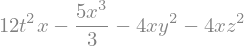

Rev D*1 I*1 F*1


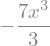


3. Rev D*2 I*2 F*1


Rev D*2 I*2 F



4. D*1e I*2e F*1


D*1e I*2e F



5. D*2e I*e F*1


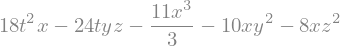

D*2e I*e F


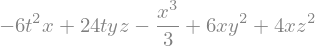


6. Rev D*e I*2e F


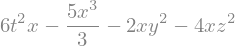

Rev D*e I*2e F*1


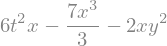


7. Rev D*2e I*1e F*1


Rev D*2e I*1e F



8. Rev De I*2e F*


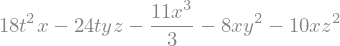

D*2 I*1 F*1


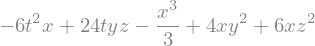


9. Rev D*1e I*2e F*1


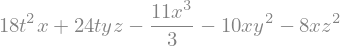

Rev D*1e I*2e F


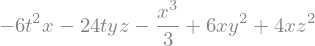


10. D*1 I* F*2


Rev De I*e F*2



11. D*2 I*1 F*1


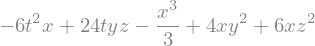

Rev De I*2e F*


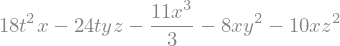


12. Rev De I*1e F*1


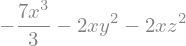

Rev De I*1e F


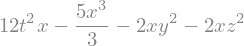


13. Rev D*e I*1e F*


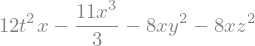

Rev D* I*1 F*1


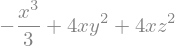


14. Rev D*1e I*2e F


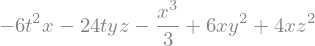

Rev D*1e I*2e F*1


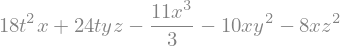


15. Rev De I*1e F


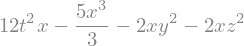

Rev De I*1e F*1


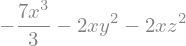


16. D*1 I*1 F*2


Rev D*1e I*e F*2



17. Rev D*2e I*2e F


Rev D*2e I*2e F*1



18. Rev D*1e I*e F*2


D*1 I*1 F*2



19. Rev D*2e I*e F*1


Rev D*2e I*e F



20. D*2e I*e F


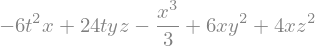

D*2e I*e F*1


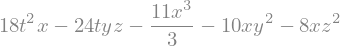


21. Rev D*1e I*1e F


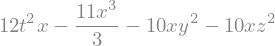

Rev D*1e I*1e F*1


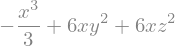


22. Rev D*1 I*1 F*1


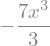

Rev D*1 I*1 F


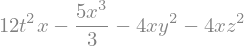


23. Rev D*2 I*1 F*1


Rev D*2 I*1 F



24. Rev D*2 I*1 F


Rev D*2 I*1 F*1



25. D*2 I*2 F*


Rev D*e I*1e F*2



26. Rev D*e I*2e F*1


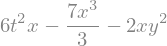

Rev D*e I*2e F


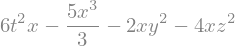


27. Rev D*1e I*1e F*1


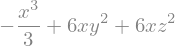

Rev D*1e I*1e F


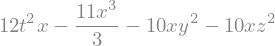


28. Rev D* I*1 F*1


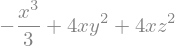

Rev D*e I*1e F*


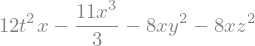


29. D*1e I*2e F


D*1e I*2e F*1



30. Rev D*1 I*2 F


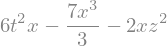

Rev D*1 I*2 F*1


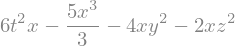


31. Rev De I*e F*2


D*1 I* F*2



32. Rev D*e I*1e F*2


D*2 I*2 F*



33. Rev D*2 I*2 F


Rev D*2 I*2 F*1



34. Rev D*2e I*e F


Rev D*2e I*e F*1



35. Rev D*1 I*2 F*1


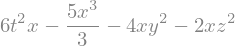

Rev D*1 I*2 F


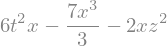


36. Rev D*2e I*1e F


Rev D*2e I*1e F*1



OK: 36


In [32]:
ok = 0
for q1 in list(all_x):
    for q2 in list(all_x):
        q12 = q1 + q2
        
        if q12 == 12 * t ** 2 * x - 4 * x ** 3 - 4 * x * y ** 2 - 4 * x * z ** 2:

            key = str(q1)
            
            print(f"{ok + 1}. {all_x_tags[key]}")
            display(q1)
            
            key = str(q2)
            print(all_x_tags[key])
            display(q2)
            
            display(q12)
            print()
            
            ok += 1
            
print(f"OK: {ok}")

1. Rev D*1 I*2 F*2


Rev D*1 I*2 F



2. D*2 I* F*1


Rev De I*e F*1



3. Rev De I*e F*1


D*2 I* F*1



4. D*1e I*e F*2


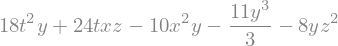

D*1e I*e F


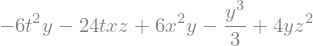


5. Rev D*e I*1e F


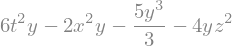

Rev D*e I*1e F*2


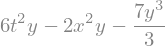


6. Rev D*2e I*1e F


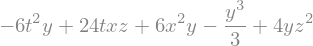

Rev D*2e I*1e F*2


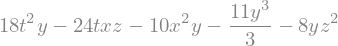


7. D*2e I*1e F


D*2e I*1e F*2



8. Rev D*2e I*2e F


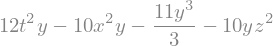

Rev D*2e I*2e F*2


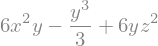


9. Rev D*2 I*1 F*2


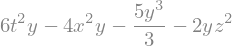

Rev D*2 I*1 F


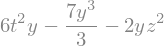


10. Rev D*2e I*2e F*2


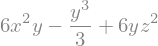

Rev D*2e I*2e F


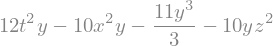


11. Rev De I*2e F


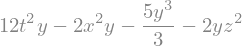

Rev De I*2e F*2


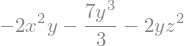


12. Rev De I*1e F*


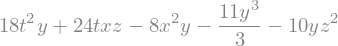

D*1 I*2 F*2


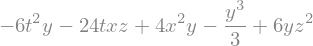


13. Rev D*1 I*1 F*2


Rev D*1 I*1 F



14. Rev D* I*2 F*2


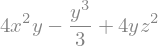

Rev D*e I*2e F*


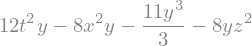


15. Rev D*1e I*1e F


Rev D*1e I*1e F*2



16. Rev D*2e I*e F*1


D*2 I*2 F*1



17. Rev D*1 I*2 F


Rev D*1 I*2 F*2



18. Rev D*1e I*e F


Rev D*1e I*e F*2



19. Rev D*e I*1e F*2


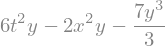

Rev D*e I*1e F


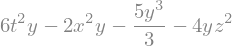


20. Rev D*e I*2e F*1


D*1 I*1 F*



21. Rev D*2 I*1 F


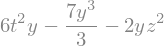

Rev D*2 I*1 F*2


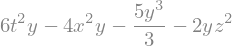


22. Rev D*1e I*e F*2


Rev D*1e I*e F



23. D*1 I*2 F*2


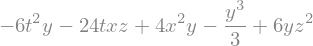

Rev De I*1e F*


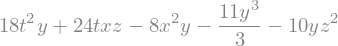


24. Rev D*2 I*2 F


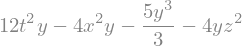

Rev D*2 I*2 F*2


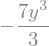


25. D*2e I*1e F*2


D*2e I*1e F



26. D*1 I*1 F*


Rev D*e I*2e F*1



27. Rev D*2 I*2 F*2


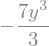

Rev D*2 I*2 F


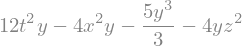


28. Rev D*1 I*1 F


Rev D*1 I*1 F*2



29. Rev D*e I*2e F*


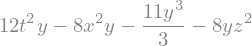

Rev D* I*2 F*2


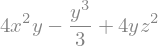


30. Rev D*1e I*2e F


Rev D*1e I*2e F*2



31. Rev D*1e I*2e F*2


Rev D*1e I*2e F



32. Rev De I*2e F*2


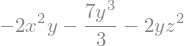

Rev De I*2e F


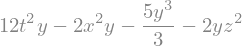


33. Rev D*2e I*1e F*2


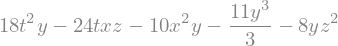

Rev D*2e I*1e F


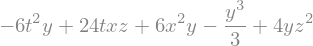


34. Rev D*1e I*1e F*2


Rev D*1e I*1e F



35. D*1e I*e F


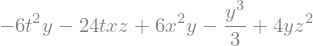

D*1e I*e F*2


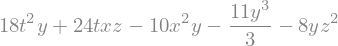


36. D*2 I*2 F*1


Rev D*2e I*e F*1



OK: 36


In [33]:
ok = 0
for q1 in list(all_y):
    for q2 in list(all_y):
        q12 = q1 + q2
        
        if q12 == 12 * t ** 2 * y - 4 * x ** 2 * y - 4 * y ** 3 - 4 * y * z ** 2:

            key = str(q1)
            
            print(f"{ok + 1}. {all_y_tags[key]}")
            display(q1)
            
            key = str(q2)
            print(all_y_tags[key])
            display(q2)
            
            display(q12)
            print()
            
            ok += 1
            
print(f"OK: {ok}")

1. Rev De I*e F*1


Rev D*2e I*2e F



2. D*2e Ie F*1


Rev D* I*1 F*1



3. D* I*2 F*2


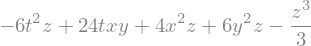

Rev De I*1e F*


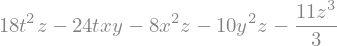


4. Rev D*1e I*2e F*2


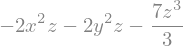

Rev D*1 I*2 F*1


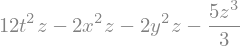


5. D*2 I*2 F*


Rev D*2e I*1e F*



6. Rev D*1e I*e F


Rev De I*1e F*2



7. D*2 I* F*1


Rev De I*1e F*1



8. Rev De I*2e F*2


D*1 I* F*2



9. Rev D* I*1 F*1


D*2e Ie F*1



10. Rev De I*1e F*


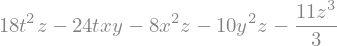

D* I*2 F*2


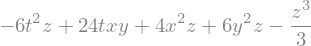


11. Rev D* I*1 F*2


De I*2e F*



12. Rev D*1 I*1 F


D*2e I*1e F



13. Rev D* I*2 F*1


De I*1e F*



14. De I*1e F*


Rev D* I*2 F*1



15. De I*1e F*2


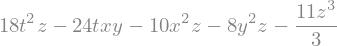

Rev D*2 I* F*1


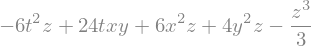


16. Rev D*2 I*1 F*


D*2e I*2e F*



17. Rev D*1e I*2e F*1


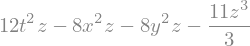

Rev D*1 I*2 F*2


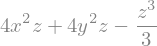


18. Rev De I*1e F*2


Rev D*1e I*e F



19. Rev D*1 I*2 F*1


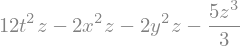

Rev D*1e I*2e F*2


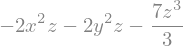


20. Rev D*2 I*2 F


D*1e I*2e F



21. D* I*1 F*1


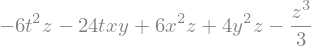

Rev De I*2e F*


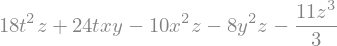


22. D*1 I* F*2


Rev De I*2e F*2



23. D*1 I*1 F*


Rev D*1e I*2e F*



24. De I*2e F*1


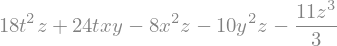

Rev D*1 I* F*2


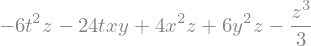


25. De I*2e F*


Rev D* I*1 F*2



26. Rev De I*e F*2


Rev D*1e I*1e F



27. D*2e I*1e F


Rev D*1 I*1 F



28. Rev D*1 I*2 F*


D*1e I*1e F*



29. Rev De I*2e F*


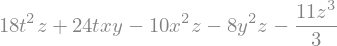

D* I*1 F*1


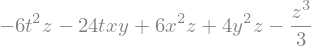


30. Rev D*1e I*2e F*


D*1 I*1 F*



31. Rev D*e I*2e F


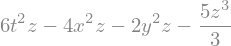

Rev D*2e Ie F*1


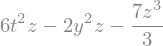


32. Rev D*2e I*2e F


Rev De I*e F*1



33. Rev De I*1e F*1


D*2 I* F*1



34. D*2e I*2e F*


Rev D*2 I*1 F*



35. Rev D*2 I* F*1


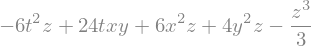

De I*1e F*2


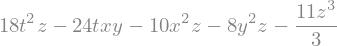


36. Rev D*2e Ie F*1


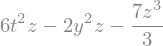

Rev D*e I*2e F


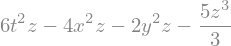


37. D*1e I*1e F*


Rev D*1 I*2 F*



38. Rev D* I*2 F*2


D*1e Ie F*2



39. Rev D*1 I*2 F*2


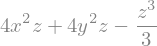

Rev D*1e I*2e F*1


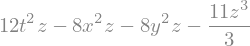


40. Rev D*1e I*1e F


Rev De I*e F*2



41. Rev De I*2e F*1


Rev D*2e I*e F



42. Rev D*2e I*e F


Rev De I*2e F*1



43. Rev D*1 I* F*2


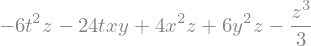

De I*2e F*1


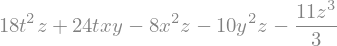


44. Rev D*1e Ie F*2


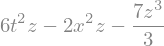

Rev D*e I*1e F


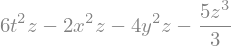


45. Rev D*2e I*1e F*


D*2 I*2 F*



46. D*1e I*2e F


Rev D*2 I*2 F



47. D*1e Ie F*2


Rev D* I*2 F*2



48. Rev D*e I*1e F


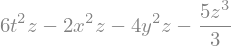

Rev D*1e Ie F*2


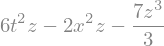


OK: 48


In [34]:
ok = 0
for q1 in list(all_z):
    for q2 in list(all_z):
        q12 = q1 + q2
        
        if q12 == 12 * t ** 2 * z - 4 * x ** 2 * z - 4 * y ** 2 * z - 4 * z ** 3:

            key = str(q1)
            
            print(f"{ok + 1}. {all_z_tags[key]}")
            display(q1)
            
            key = str(q2)
            print(all_z_tags[key])
            display(q2)
            
            display(q12)
            print()
            
            ok += 1
            
print(f"OK: {ok}")

1. Rev De I*e F*1


D*2 I*1 F*



2. D*2e Ie F*1


De I*2e F



3. D* I*2 F*2


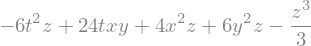

Rev D*e I*1e F*


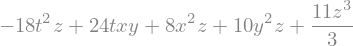


4. D*2 I*2 F*


D*1 I*1 F



5. Rev D*1e I*e F


Rev D*e I*1e F*2



6. D*2 I* F*1


Rev D*e I*1e F*1



7. Rev De I*e F*


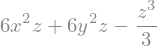

Rev D*2 I*2 F*1


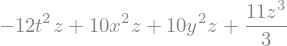


8. Rev D* I*1 F*1


D*2e I*e F*1



9. Rev D* I*1 F*2


Rev D*1 I* F



10. Rev D*1 I*1 F


Rev D*2 I*2 F*



11. Rev D* I*2 F*1


Rev D*2 I* F



12. De I*1e F*2


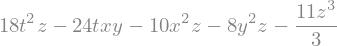

D*1e Ie F


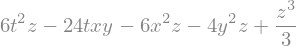


13. Rev D*2 I*1 F*


Rev D*1 I*2 F



14. Rev D*1e I*2e F*1


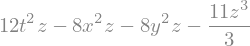

D*e I*e F


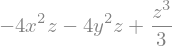


15. Rev De I*1e F*2


Rev D*1e Ie F



16. Rev D*1 I*2 F*1


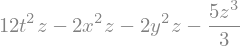

De I*e F*


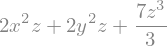


17. Rev D*2 I*2 F


Rev D*1 I*1 F*



18. D* I*1 F*1


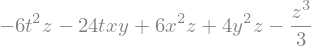

Rev D*e I*2e F*


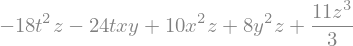


19. D*1 I* F*2


Rev D*e I*2e F*2



20. D*1 I*1 F*


D*2 I*2 F



21. De I*2e F*1


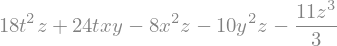

D*2e Ie F


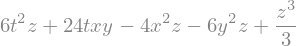


22. Rev De I*e F*2


D*1 I*2 F*



23. D*2e I*1e F


D*1e I*2e F*



24. Rev D*1 I*2 F*


Rev D*2 I*1 F



25. Rev D*1e I*2e F*


Rev D*2e I*1e F



26. Rev D*e I*2e F


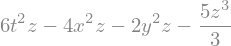

Rev D*2e I*e F*1


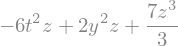


27. Rev D*2e I*2e F


Rev D*1e I*1e F*



28. Rev D*e I*e F


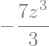

Rev D*2e I*2e F*1


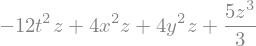


29. D*2e I*2e F*


D*1e I*1e F



30. Rev D*2 I* F*1


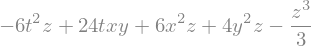

Rev D* I*2 F


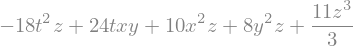


31. Rev D*2e Ie F*1


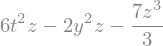

Rev De I*2e F


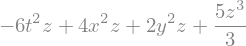


32. D*1e I*1e F*


D*2e I*2e F



33. Rev D* I*2 F*2


D*1e I*e F*2



34. Rev D*1e I*1e F


Rev D*2e I*2e F*



35. Rev De I*2e F*1


Rev D*2e Ie F



36. Rev D*2e I*e F


Rev D*e I*2e F*1



37. Rev D*1 I* F*2


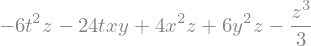

Rev D* I*1 F


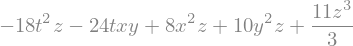


38. Rev D*1e Ie F*2


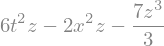

Rev De I*1e F


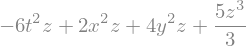


39. Rev D*2e I*1e F*


Rev D*1e I*2e F



40. D*1e I*2e F


D*2e I*1e F*



41. D*1e Ie F*2


De I*1e F



42. Rev D*e I*1e F


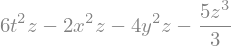

Rev D*1e I*e F*2


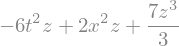


OK: 42


In [35]:
ok = 0
for q1 in list(all_z):
    for q2 in list(all_z):
        q12 = q1 - q2
        
        if q12 == 12 * t ** 2 * z - 4 * x ** 2 * z - 4 * y ** 2 * z - 4 * z ** 3:

            key = str(q1)
            
            print(f"{ok + 1}. {all_z_tags[key]}")
            display(q1)
            
            key = str(q2)
            print(all_z_tags[key])
            display(q2)
            
            display(q12)
            print()
            
            ok += 1
            
print(f"OK: {ok}")

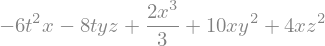

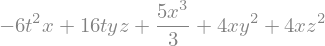

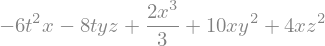

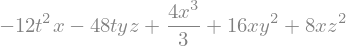

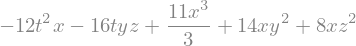

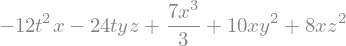

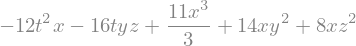

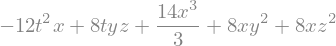

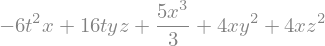

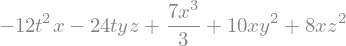

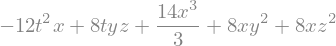

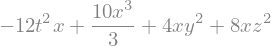

In [36]:
all_x_list = list(all_x)

for i in range(4):
    for j in range(4):
        display(all_x_list[i] + all_x_list[j])

q1


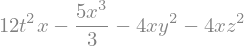

q2


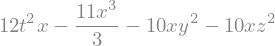

q1 + q2


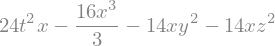

In [37]:
q1 = Dq(Iq(conj(q_txyz_3, conj_type=1), [t, x, y, z], [t, x, y, z], conj=False, reverse=True), [t, x, y, z], [t, x, y, z], conj=False).expand()
q2 = Dq(Iq(conj(q_txyz_3, conj_type=1), [t, x, y, z], [t, x, y, z], conj=True, reverse=True), [t, x, y, z], [t, x, y, z], conj=True).expand()
q12 = add(q1, q2)

q1.display("q1")
q2.display("q2")
q12.display("q1 + q2")

In [38]:
q1 = Dq(Iq(conj(q_txyz, conj_type=1), [t, x, y, z], [t, x, y, z], conj=False, reverse=True), [t, x, y, z], [t, x, y, z], conj=False).expand()
q2 = Dq(Iq(conj(q_txyz, conj_type=1), [t, x, y, z], [t, x, y, z], conj=True, reverse=True), [t, x, y, z], [t, x, y, z], conj=True).expand()
q12 = add(q1, q2)
q_txyz.display("q_txyz")
q12.display("q1 + q2")

q_txyz


q1 + q2


q_txyz 4


q1 + q2


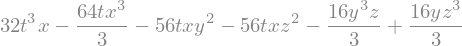

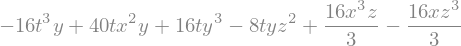

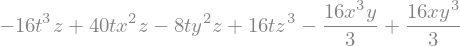

In [39]:
q4 = product(q_txyz, q_txyz_3)
q1 = Dq(Iq(conj(q4, conj_type=1), [t, x, y, z], [t, x, y, z], conj=False, reverse=True), [t, x, y, z], [t, x, y, z], conj=False).expand()
q2 = Dq(Iq(conj(q4, conj_type=1), [t, x, y, z], [t, x, y, z], conj=True, reverse=True), [t, x, y, z], [t, x, y, z], conj=True).expand()
q12 = add(q1, q2)
q4.expand().display("q_txyz 4")
q12.display("q1 + q2")

In [40]:
q1 = Dq(Iq(conj(Q([t, x,0,0]), conj_type=1), [t, x, y, z], [t, x, y, z], conj=False, reverse=True), [t, x, y, z], [t, x, y, z], conj=False).expand()
q2 = Dq(Iq(conj(Q([t, x,0,0]), conj_type=1), [t, x, y, z], [t, x, y, z], conj=True, reverse=True), [t, x, y, z], [t, x, y, z], conj=True).expand()
q12 = add(q1, q2)
q12.display("q1 + q2")

q1 + q2


In [41]:
q1 = Dq(Iq(conj(square(Q([t, x,0,0])), conj_type=1), [t, x, y, z], [t, x, y, z], conj=False, reverse=True), [t, x, y, z], [t, x, y, z], conj=False).expand()
q2 = Dq(Iq(conj(square(Q([t, x,0,0])), conj_type=1), [t, x, y, z], [t, x, y, z], conj=True, reverse=True), [t, x, y, z], [t, x, y, z], conj=True).expand()
q12 = add(q1, q2)
q12.display("q1 + q2")

q1 + q2


q1


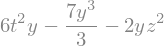

q2


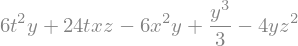

q1 + q2


In [42]:
q1 = Dq(Iq(q_txyz_3, [t, x, y, z], [t, x, y, z], conj=True, conj_type=1, reverse=True), [t, x, y, z], [t, x, y, z], conj=True, conj_type=2).expand()
q2 = Dq(Iq(conj(q_txyz_3, conj_type=0), [t, x, y, z], [t, x, y, z], conj=True, conj_type=1, reverse=True), [t, x, y, z], [t, x, y, z], conj=True, conj_type=2).expand()
q12 = add(q1, q2)

q1.display("q1")
q2.display("q2")
q12.display("q1 + q2")

In [43]:
ok = 0
for q1 in list(all_ID_qs):
    for q2 in list(all_ID_qs):
        q12 = q1 + q2
        
        if q12 == t**3 - 3 * t * x**2 - 3 * t * y ** 2 - 3 * t * z **2:
            print("gots it")
            print(f"q1: {q1}")
            print(f"q2: {q2}")
            print(f"q12: {q12}")
            
            ok += 1
            
print(f"OK: {ok}")

NameError: name 'all_ID_qs' is not defined

In [ ]:
ok = 0
for q1 in list(all_ID_qs):
    for q2 in list(all_ID_qs):
        q12 = q1 + q2
        
        if q12 == 2 * t**3 - 6 * t * x**2 - 6 * t * y ** 2 - 6 * t * z **2:
            print("gots it")
            print(f"q1: {q1}")
            print(f"q2: {q2}")
            print(f"q12: {q12}")
            
            ok += 1
            
print(f"OK: {ok}")

In [ ]:
def fundamental_t(fun, vars: List[sp.Symbol]):
    q1 = Dq(Iq(conj(square(Q([t, x,0,0]), conj_type=1), vars, vars, conj=False, reverse=True), vars, vars, conj=False).expand()
    q2 = Dq(Iq(conj(square(Q([t, x,0,0])), conj_type=1), vars, vars, conj=True, reverse=True), vars, vars, conj=True).expand()
    q12 = add(q1, q2)
    